# Demonstrate Transfer Learning and Fine Tuning

using <h3>InceptionV3</h3>

## Library Imports

In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load the image dataset

In [2]:
PARENT_DIR = os.environ.get("ONE_DRIVE")
DATA_DIR = 'Datasets/LargeDatasets/cats_and_dogs_filtered'
DATA_DIR = os.path.join(PARENT_DIR, DATA_DIR)
print(DATA_DIR)

/Users/suvosmac/OneDrive/Datasets/LargeDatasets/cats_and_dogs_filtered


In [3]:
print(DATA_DIR)
# Define the training and validation paths

train_dir = os.path.join(DATA_DIR, 'train')
validation_dir = os.path.join(DATA_DIR, 'validation')

# Directory for training images
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory for validation images
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Check the first five names of the cats ang dogs
cats_fnames = os.listdir(train_cats_dir)
dogs_fnames = os.listdir(validation_dogs_dir)

print(f"First 5 names of the cats training images - {cats_fnames[:5]}")
print(f"First 5 names of the dogs training images - {dogs_fnames[:5]}")

print(f"Total Training Cats Images - {len(os.listdir(train_cats_dir))}")
print(f"Total training dogs Images - {len(os.listdir(train_dogs_dir))}")
print(f"Total validation cats Images - {len(os.listdir(validation_cats_dir))}")
print(f"Total validation dogs Images - {len(os.listdir(validation_dogs_dir))}")

/Users/suvosmac/OneDrive/Datasets/LargeDatasets/cats_and_dogs_filtered
First 5 names of the cats training images - ['cat.952.jpg', 'cat.946.jpg', 'cat.6.jpg', 'cat.749.jpg', 'cat.991.jpg']
First 5 names of the dogs training images - ['dog.2266.jpg', 'dog.2272.jpg', 'dog.2299.jpg', 'dog.2058.jpg', 'dog.2064.jpg']
Total Training Cats Images - 1000
Total training dogs Images - 1000
Total validation cats Images - 500
Total validation dogs Images - 500


## Build the Image data generators

In [4]:
# we will preprocess the image, before we will apply the image to model for training
# Adding data augmentation parameters

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note that validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow training images in the batches of 20 using train datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size=(150, 150))

# Flow validation images in the batches of 20 using test datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Building the Model
### Loading the model InceptionV3

In [5]:
IMAGE_SHAPE = (150, 150, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
base_model.summary()

2022-07-21 20:38:03.443234: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Freezing the base model

In [6]:
base_model.trainable = False

### Defining the custom head for our network

In [7]:
# Check the output layer of the base model
base_model.output

<KerasTensor: shape=(None, 3, 3, 2048) dtype=float32 (created by layer 'mixed10')>

In [8]:
# We can flatten the output layer to one dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 1024 hidden units and relu activation
x = tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)(x)
# Add dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# Add the final sigmoid layer for output
x = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(inputs=base_model.inputs, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train the Model

In [9]:
model_fit = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

2022-07-21 20:38:05.492560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/5
100/100 [==============================] - 45s 427ms/step - loss: 2.4076 - accuracy: 0.7869 - val_loss: 0.1669 - val_accuracy: 0.9540
Epoch 2/5
100/100 [==============================] - 43s 426ms/step - loss: 0.5020 - accuracy: 0.8841 - val_loss: 0.1585 - val_accuracy: 0.9570
Epoch 3/5
100/100 [==============================] - 43s 429ms/step - loss: 0.3704 - accuracy: 0.9058 - val_loss: 0.1588 - val_accuracy: 0.9570
Epoch 4/5
100/100 [==============================] - 46s 460ms/step - loss: 0.3700 - accuracy: 0.9089 - val_loss: 0.2637 - val_accuracy: 0.9380
Epoch 5/5
100/100 [==============================] - 48s 479ms/step - loss: 0.3289 - accuracy: 0.9134 - val_loss: 0.3405 - val_accuracy: 0.9180


## Transfer learning Model evaluation

In [10]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss - {validation_loss}")
print(f"Validation Accuracy - {validation_accuracy}")

50/50 [==============================] - 8s 160ms/step - loss: 0.3405 - accuracy: 0.9180
Validation Loss - 0.34047532081604004
Validation Accuracy - 0.9179999828338623


Validation Accuracy = 0.9179999828338623


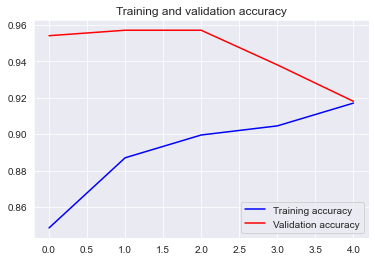

<Figure size 432x288 with 0 Axes>

In [11]:
print(f"Validation Accuracy = {validation_accuracy}")
# We will plot the training accuracy vs validation accuracy

acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

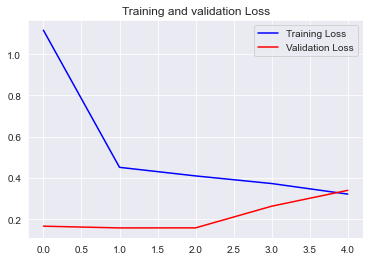

<Figure size 432x288 with 0 Axes>

In [12]:
# We will plot the training loss vs validation loss

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

## Fine Tuning

Another approach to this problem would be not using all the layers of Inception-v3.

In [13]:
last_layer = base_model.get_layer('mixed7')
print(f'Last layer output = {last_layer.output_shape}')

Last layer output = (None, 7, 7, 768)


In [14]:
# We can flatten the output layer to one dimension
x = tf.keras.layers.Flatten()(last_layer.output)

# Add a fully connected layer with 1024 hidden units and relu activation
x = tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)(x)
# Add dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# Add the final sigmoid layer for output
x = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(inputs=base_model.inputs, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [19]:
# Now we will define a callback with threshold of 95%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('acc') > 0.95:
            print(f"Reached 95% accuracy so exiting training")
            self.model.stop_training = True

In [21]:
# Perform the training once again
#myCallback = MyCallback()
model_fit = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
100/100 [==============================] - 54s 536ms/step - loss: 0.2323 - accuracy: 0.9130 - val_loss: 0.1239 - val_accuracy: 0.9500
Epoch 2/5
100/100 [==============================] - 56s 560ms/step - loss: 0.1815 - accuracy: 0.9310 - val_loss: 0.2000 - val_accuracy: 0.9470
Epoch 3/5
100/100 [==============================] - 56s 556ms/step - loss: 0.2035 - accuracy: 0.9370 - val_loss: 0.1149 - val_accuracy: 0.9640
Epoch 4/5
100/100 [==============================] - 56s 557ms/step - loss: 0.1673 - accuracy: 0.9400 - val_loss: 0.1272 - val_accuracy: 0.9580
Epoch 5/5
100/100 [==============================] - 59s 585ms/step - loss: 0.1914 - accuracy: 0.9345 - val_loss: 0.1043 - val_accuracy: 0.9610


In [22]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss - {validation_loss}")
print(f"Validation Accuracy - {validation_accuracy}")

50/50 [==============================] - 8s 157ms/step - loss: 0.1043 - accuracy: 0.9610
Validation Loss - 0.104308120906353
Validation Accuracy - 0.9610000252723694
